In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from joblib import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv(r"Credit.csv")
df = df.drop(columns=["Unnamed: 0"])
dfy = df["Rating"]
df.head(5)
#df["Income"] = np.log(df["Income"])

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [2]:
numeric_columns = df.select_dtypes(include =[np.number]).columns.tolist()
cat_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
cat_columns

['Gender', 'Student', 'Married', 'Ethnicity']

In [3]:
new_df = df.drop(columns=["Rating", "Limit", "Age", "Balance"])
numeric_columns2 = new_df.select_dtypes(include =[np.number]).columns.tolist()

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder

class MyLabelBinarizer(BaseEstimator,TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = OneHotEncoder(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

class DataframeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, atrib_names):
        self.atribute_names = atrib_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=0):
        return X[self.atribute_names].values
    

num_pipeline = Pipeline([
    ('selector', DataframeSelector(numeric_columns2)),
    ('std_scaler', StandardScaler())
])
#categorial pipeline
cat_pipeline = Pipeline([
    ('selector', DataframeSelector(cat_columns)),
    ('onehot', MyLabelBinarizer())
])
##union piplines
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipline", cat_pipeline)
])

X_data = new_df[numeric_columns2+cat_columns]
y_new = df["Rating"]


X_train, X_test, y_train, y_test = train_test_split(X_data, y_new, test_size=0.2, random_state =2)

full_pipeline.fit(X_data)
X_train_trans = full_pipeline.transform(X_train)
X_test_trans = full_pipeline.transform(X_test)
X_test_trans[5].toarray()
print(np.shape(y_test.ravel()), np.shape(X_test_trans), np.shape(X_test))
print(np.shape(y_train.ravel()), np.shape(X_train_trans), np.shape(X_train))

(80,) (80, 12) (80, 7)
(320,) (320, 12) (320, 7)


[22:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Cross validation

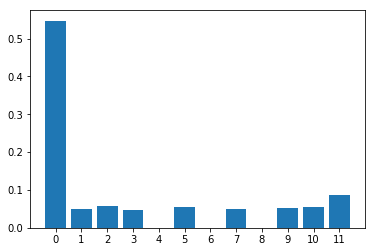

In [5]:
model_xgb = XGBRegressor(random_state=2)
model_xgb.fit(X_train_trans, y_train)
cv = cross_val_score(model_xgb, X_train_trans, y_train, cv=5)
model_score = model_xgb.score(X_test_trans, y_test)
prediction = model_xgb.predict(X_test_trans)

print(f"Cross validation score: {cv.mean()}")
print(f"Model score: {model_score}")

plt.bar(range(len(model_xgb.feature_importances_)), model_xgb.feature_importances_)
plt.xticks(range(0,len(model_xgb.feature_importances_), 1))
plt.show()

### Model tuning


In [6]:
estimators = {"n_estimators": [1,2,5,10,50,100,200,1000]}
grid_serach1 = GridSearchCV(model_xgb, estimators, cv=5)
grid_serach1.fit(X_train_trans, y_train)

best_params1 = grid_serach1.best_params_
best_score = grid_serach1.best_score_
print(f"Best score: {best_score}")
print(f"Number of esitmators: {best_params1}")

[22:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:40] WARNI

In [7]:
model_xgb_tuned1 = XGBRegressor(random_state=2, n_estimators=best_params1["n_estimators"])

learning_rate = {"learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5, 1]}

grid_serach2 = GridSearchCV(model_xgb_tuned1, learning_rate, cv=5)
grid_serach2.fit(X_train_trans, y_train)

best_params2 = grid_serach2.best_params_
best_score = grid_serach2.best_score_

print(f"Best score: {best_score}")
print(f"Number of esitmators: {best_params2}")

[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNI

In [8]:
model_xgb_tuned2 = XGBRegressor(random_state=2, 
                                learning_rate=best_params2["learning_rate"],
                                n_estimators=best_params1["n_estimators"])
regularization = {"max_depth" : [1,2,3],
                  "min_child_weight" : [0,0.5,1,2,3,4,5]}

grid_serach3 = GridSearchCV(model_xgb_tuned2, regularization, cv=5)
grid_serach3.fit(X_train_trans, y_train)

best_params3 = grid_serach3.best_params_
best_score = grid_serach3.best_score_

print(f"Best score: {best_score}")
print(f"Number of esitmators: {best_params3}")

[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:41] WARNI

[22:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:42] WARNI

[22:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 0.5741967056619275
Number of esitmators: {'max_depth': 1, 'min_child_weight': 5}


In [9]:
model_xgb_tuned3 = XGBRegressor(random_state=2, 
                                learning_rate=best_params2["learning_rate"],
                                n_estimators=best_params1["n_estimators"],
                                max_depth=best_params3["max_depth"],
                                min_child_weight=best_params3["min_child_weight"]
                               )
gamma = {'gamma':[i/10.0 for i in range(0,20)]}

grid_serach4 = GridSearchCV(model_xgb_tuned3, gamma, cv=5)
grid_serach4.fit(X_train_trans, y_train)

best_params4 = grid_serach4.best_params_
best_score = grid_serach4.best_score_

print(f"Best score: {best_score}")
print(f"Number of esitmators: {best_params4}")

[22:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNI

[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNI

In [10]:
model_xgb_tuned4 = XGBRegressor(random_state=2, 
                                learning_rate=best_params2["learning_rate"],
                                n_estimators=best_params1["n_estimators"],
                                max_depth=best_params3["max_depth"],
                                min_child_weight=best_params3["min_child_weight"],
                                gamma = best_params4["gamma"]
                               )
param_test5 = {
 'subsample':[i/100.0 for i in range(20,100,5)],
 'colsample_bytree':[i/100.0 for i in range(50,100,5)]}


grid_serach5 = GridSearchCV(model_xgb_tuned4, param_test5, cv=5)
grid_serach5.fit(X_train_trans, y_train)

best_params5 = grid_serach5.best_params_
best_score = grid_serach5.best_score_

print(f"Best score: {best_score}")
print(f"Number of esitmators: {best_params5}")

[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:43] WARNI

[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNI

[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:44] WARNI

[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNI

[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:45] WARNI

[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNI

[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:46] WARNI

[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNI

[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:47] WARNI

[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNI

[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNI

[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNI

[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:49] WARNI

[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNI

[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:50] WARNI

In [11]:
model_xgb_tuned5 = XGBRegressor(random_state=2, 
                                learning_rate=best_params2["learning_rate"],
                                n_estimators=best_params1["n_estimators"],
                                max_depth=best_params3["max_depth"],
                                min_child_weight=best_params3["min_child_weight"],
                                gamma = best_params4["gamma"],
                                subsample = best_params5["subsample"],
                                colsample_bytree = best_params5["colsample_bytree"]
                               )
regularization = {
 'reg_alpha':[1e-5, 1e-2, 0.1,  2,5,100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 2,5,100]}


grid_serach6 = GridSearchCV(model_xgb_tuned5, regularization, cv=5)
grid_serach6.fit(X_train_trans, y_train)

best_params6 = grid_serach6.best_params_
best_score = grid_serach6.best_score_

print(f"Best score: {best_score}")
print(f"Number of esitmators: {best_params6}")

[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNI

[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:51] WARNI

[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNI

[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:52] WARNI

In [12]:
model_xgb_tuned6 = XGBRegressor(random_state=2, 
                                learning_rate=best_params2["learning_rate"],
                                n_estimators=best_params1["n_estimators"],
                                max_depth=best_params3["max_depth"],
                                min_child_weight=best_params3["min_child_weight"],
                                gamma = best_params4["gamma"],
                                subsample = best_params5["subsample"],
                                colsample_bytree = best_params5["colsample_bytree"],
                                reg_alpha=best_params6["reg_alpha"],
                                reg_lambda=best_params6["reg_lambda"]
                               )
booster = {"booster": ["gbtree", "dart","gblinear"],
          "grow_policy" : ["depthwise", "lossguide"]}
          

grid_serach7 = GridSearchCV(model_xgb_tuned6, booster, cv=5)
grid_serach7.fit(X_train_trans, y_train)

best_params7 = grid_serach7.best_params_
best_score = grid_serach7.best_score_

print(f"Best score: {best_score}")
print(f"Number of esitmators: {best_params7}")

[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNI

In [13]:
model_xgb_tuned7 = XGBRegressor(random_state=2, 
                                learning_rate=best_params2["learning_rate"],
                                n_estimators=best_params1["n_estimators"],
                                max_depth=best_params3["max_depth"],
                                min_child_weight=best_params3["min_child_weight"],
                                gamma = best_params4["gamma"],
                                subsample = best_params5["subsample"],
                                colsample_bytree = best_params5["colsample_bytree"],
                                reg_alpha=best_params6["reg_alpha"],
                                reg_lambda=best_params6["reg_lambda"],
                                booster=best_params7["booster"],
                                grow_policy = best_params7["grow_policy"]
                               )
updater = {"max_leaves" : [0,1,2,3,4,5,10]}
        #"updater" : ["grow_histmaker", "grow_local_histmaker",
                    #"grow_skmaker", "sync", "refresh", "prune"]}
          

grid_serach8 = GridSearchCV(model_xgb_tuned7, updater, cv=5)
grid_serach8.fit(X_train_trans, y_train)

best_params8 = grid_serach8.best_params_
best_score = grid_serach8.best_score_

print(f"Best score: {best_score}")
print(f"Number of esitmators: {best_params8}")

[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNI

In [14]:
model_xgb_tuned = XGBRegressor(random_state=2, 
                                learning_rate=best_params2["learning_rate"],
                                n_estimators=best_params1["n_estimators"],
                                max_depth=best_params3["max_depth"],
                                min_child_weight=best_params3["min_child_weight"],
                                gamma = best_params4["gamma"],
                                subsample = best_params5["subsample"],
                                colsample_bytree = best_params5["colsample_bytree"],
                                reg_alpha=best_params6["reg_alpha"],
                                reg_lambda=best_params6["reg_lambda"],
                                booster=best_params7["booster"],
                                grow_policy = best_params7["grow_policy"],
                                max_leaves = best_params8["max_leaves"],
                                early_stopping_rounds=50)

model_xgb_tuned.fit(X_train_trans, y_train)
cv = cross_val_score(model_xgb_tuned, X_train_trans, y_train, cv=5)
model_score = model_xgb_tuned.score(X_test_trans, y_test)
prediction = model_xgb_tuned.predict(X_test_trans)

print(f"Cross validation score: {cv.mean()}")
print(f"Model score: {model_score}")

#plt.bar(range(len(model_xgb_tuned.feature_importances_)), model_xgb_tuned.feature_importances_)
#plt.xticks(range(0,len(model_xgb_tuned.feature_importances_), 1))
#plt.show()

[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Cross validation

In [15]:
pred = model_xgb_tuned.predict(X_test_trans)
print(f"Prediction values: {pred}")
print(f"real values:{np.array(y_test)}")

Prediction values: [322.6182  655.02423 252.10231 377.38428 316.63214 253.32571 235.48807
 399.41458 474.0647  419.2751  294.23587 255.16435 393.66086 254.5329
 544.2688  472.02094 666.65155 245.13487 275.67026 551.8747  232.13931
 274.80786 352.39478 322.291   292.08923 266.4172  257.4807  334.60522
 260.42822 252.74261 304.8142  305.73538 238.17087 242.9716  429.92377
 538.49854 309.39005 254.24579 828.7131  521.68713 270.6002  411.51276
 262.54636 259.60446 511.86826 236.85489 397.48434 326.49313 240.63312
 414.61237 263.14926 306.61108 605.82025 580.03015 454.67224 295.4732
 283.59265 336.11343 244.26822 327.1421  255.65532 374.50504 339.18906
 419.61334 309.40662 304.34583 320.67273 284.38818 375.81296 306.88248
 258.5616  393.60187 562.1192  295.39514 433.61667 472.41782 296.12674
 250.51764 232.34497 310.48425]
real values:[245 563 411 406 442 326 380 326 536 527 316 253 459 204 549 335 730 138
 420 514 296 196 232 192 318 129 235 369 409 381 154 282 156 103 512 633
 289 413 949

## Saving trained model

In [16]:
import pickle
filename = 'model_xgb_tuned_without_balance.sav'
pickle.dump(model_xgb_tuned, open(filename, 'wb'))
dump(model_xgb_tuned, 'model_xgb_tuned_without_balance.joblib')


['model_xgb_tuned_without_balance.joblib']

In [17]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_trans, y_test)
print(result)

[22:22:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.6591135354613579


## Połączone siły modeli

In [18]:
from sklearn.ensemble import RandomForestRegressor

ran = RandomForestRegressor(random_state=2)
ran.fit(X_train_trans, y_train)

params = {
    "n_estimators" : [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    "max_features" : ['auto', 'sqrt'],
    "max_depth" : [int(x) for x in np.linspace(10, 110, num = 11)],
    "min_samples_split" : [2, 5, 10],
    "min_samples_leaf" : [1, 2, 4],
    "bootstrap" : [True, False]
}
random = RandomizedSearchCV(ran, params,cv=5)
random.fit(X_train_trans, y_train)
random.best_score_
bp = random.best_params_
random.best_params_

ran = RandomForestRegressor(random_state=2,
                           n_estimators=bp["n_estimators"],
                           max_features=bp["max_features"],
                           max_depth = bp["max_depth"],
                           min_samples_split = bp["min_samples_split"],
                            min_samples_leaf = bp["min_samples_leaf"],
                            bootstrap = bp["bootstrap"]
                           )

In [19]:
from sklearn.svm import SVR

model_svr = SVR()

params2 = {"gamma": [x for x in np.arange(0.05,1,0.05)],
           "C": [x for x in np.arange(0.1,10,0.1)],
           "kernel" : ["rbf", "linear", "sigmoid"]}

random2 = RandomizedSearchCV(model_svr, params2, cv=5, n_jobs=-1)
random2.fit(X_train_trans, y_train)
random2.best_score_
bp2 = random2.best_params_
random2.best_params_
print(random2.best_score_)
model_svr_tuned = SVR(
                     C=bp2["C"],
                     gamma=bp2["gamma"],
                     kernel=bp2["kernel"])

0.5710293809133165


Accuracy: 0.5297 (+/- 0.09), Estimator: Ridge
Score:0.5780601292440497


C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356674, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm d

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294345, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this alg

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this alg

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336698, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, 

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336631, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336698, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336698, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336698, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336698, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, 

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336631, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3472210.0873399433, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3472210.0873399433, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1432137.9347857214, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2306217.3456207784, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2306217.3456207784, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2306217.3456207784, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32229.129685229855, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32229.129685229855, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32229.129685229855, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151621.14003431518, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151621.14003431518, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151621.14003431518, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1007683.750421129, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1007683.750421129, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1007683.750421129, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57689.39399961592, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57689.39399961592, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1019713.744256025, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2038227.9564299092, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2038227.9564299092, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2038227.9564299092, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3640503.4174596914, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3640503.4174596914, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1511308.7613178152, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53684.36130775465, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53684.36130775465, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53684.36130775465, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3702995.232183657, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3702995.232183657, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1575883.4110057524, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2005638.2818916973, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3754895.8583963346, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3754895.8583963346, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6439.984940582886, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6439.984940582886, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149942.69506990537, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3735599.583117774, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1631622.126953545, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1631622.126953545, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-package

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4388829.001191115, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3735599.583117774, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3735599.583117774, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2250531.3528959583, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4975849.899747039, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4975849.899747039, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2064622.6880467327, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2064622.6880467327, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3824302.255598951, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3568381.6106199673, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1418379.8127821654, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1418379.8127821654, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5522439.95215098, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5522439.95215098, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5522439.95215098, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coor

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2349917.552167765, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5522439.95215098, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5522439.95215098, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_m

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61422.70838433551, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61422.70838433551, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3828582.4688995797, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3639327.971240923, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1477993.125202134, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1477993.125202134, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-package

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3275807.3095174246, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3275807.3095174246, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3275807.3095174246, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3786320.035940675, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1805402.656885087, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1805402.656885087, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-package

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3786320.035940675, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3786320.035940675, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1805402.656885087, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-package

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2585144.4444358726, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6965031.992842452, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6965031.992842452, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3830967.208192972, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2585144.4444358726, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2585144.4444358726, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3831803.025601664, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3831803.025601664, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2647843.4678367265, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7391351.06759016, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7391351.06759016, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7391351.06759016, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coor

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2718204.1137222555, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3832487.323857232, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3832487.323857232, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1571001.6222370693, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1571001.6222370693, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2834497.3223352516, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4055145.1924769096, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4055145.1924769096, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3708065.4838912557, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3803732.7727419357, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1936370.2597193976, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1936370.2597193976, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8177049.483881699, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8177049.483881699, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8177049.483881699, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3833540.878008876, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3833540.878008876, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2803196.106178008, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-package

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2803196.106178008, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8540213.442897137, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8540213.442897137, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3056412.1039100727, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3056412.1039100727, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3833955.035730381, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3734967.3424060512, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1626727.5453039953, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1626727.5453039953, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4574522.067386578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4574522.067386578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4574522.067386578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3810771.0902352217, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3810771.0902352217, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2018600.7219767324, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9214925.131265841, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9214925.131265841, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9214925.131265841, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9529048.159616444, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834628.356884178, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834628.356884178, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9529048.159616444, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9529048.159616444, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9529048.159616444, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3366737.7835842045, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834905.720145102, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834905.720145102, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1674491.3243588058, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1674491.3243588058, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3465021.681109928, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5053673.35216713, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5053673.35216713, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3752718.906843313, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_m

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3815486.8456734447, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2091335.4989969996, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2091335.4989969996, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10116262.858609568, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10116262.858609568, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10116262.858609568, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3835373.0078542754, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3835373.0078542754, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3017440.032802477, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3017440.032802477, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10391204.974929258, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10391204.974929258, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3654841.3411062052, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3654841.3411062052, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3835571.661997211, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3765310.244604277, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1716297.453174155, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1716297.453174155, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-package

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5500485.354507778, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5500485.354507778, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5500485.354507778, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10907742.806624064, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3818866.85033919, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3818866.85033919, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3070425.1845588987, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3070425.1845588987, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10907742.806624064, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11150719.27865928, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11150719.27865928, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3835914.871811741, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3094434.649555237, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11150719.27865928, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11150719.27865928, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3924617.230373297, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3924617.230373297, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836064.12505967, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3774705.913577823, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1753455.3146685637, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1753455.3146685637, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5920166.963612598, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5920166.963612598, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5920166.963612598, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3821408.2313529854, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2216243.5531824017, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2216243.5531824017, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11609104.29480987, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11609104.29480987, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11609104.29480987, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836326.857291416, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3158233.738751121, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3158233.738751121, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-package

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11825572.351157602, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11825572.351157602, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11825572.351157602, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836443.084705695, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836443.084705695, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3177138.0380952875, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1786879.1843453762, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4260608.075982135, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4260608.075982135, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6316417.287461497, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6316417.287461497, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3781985.5188472318, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3823388.653289764, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2270849.3497445663, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2270849.3497445663, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12235401.086089674, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12235401.086089674, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3823388.653289764, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3211962.998075862, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12429592.666814584, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12429592.666814584, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836650.6625409294, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836650.6625409294, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3211962.998075862, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12617138.898645211, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12617138.898645211, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12617138.898645211, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4497495.729355071, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836743.726695723, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836743.726695723, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1817237.356893789, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1817237.356893789, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4497495.729355071, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6813008.090396163, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6813008.090396163, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6813008.090396163, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3824975.386303074, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3824975.386303074, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2321297.37118728, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12973645.722605173, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12973645.722605173, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12973645.722605173, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12973645.722605173, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836911.861456738, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836911.861456738, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13143223.559970576, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13143223.559970576, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13143223.559970576, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4723197.6477288855, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836988.055518527, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3836988.055518527, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845034.9986141408, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845034.9986141408, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4723197.6477288855, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7164363.999285607, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7164363.999285607, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7164363.999285607, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3826275.2095282557, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2368153.950414349, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2368153.950414349, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13466418.266591916, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3826657.7827051915, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3826657.7827051915, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13466418.266591916, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13466418.266591916, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13466418.266591916, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13620537.231518168, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837190.538266611, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837190.538266611, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3309483.389018901, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13620537.231518168, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13620537.231518168, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4938962.198136887, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4938962.198136887, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837250.539920756, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3797641.727012346, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878780.5530186896, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878780.5530186896, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7499507.658707472, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7499507.658707472, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7499507.658707472, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3827682.033649723, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3827682.033649723, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2425802.166993016, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-package

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13914956.119221965, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13914956.119221965, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3827682.033649723, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3342574.860346815, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14055669.332904428, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14055669.332904428, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14055669.332904428, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837361.077381506, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837361.077381506, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3352705.385448878, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14192306.546727013, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14192306.546727013, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5212931.403020426, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5212931.403020426, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837412.0982119148, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3800798.3014669903, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1901989.7195372798, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1901989.7195372798, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7923497.0794900805, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7923497.0794900805, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7923497.0794900805, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14325044.760050632, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3828553.3449853277, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3828553.3449853277, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3371775.255421745, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3371775.255421745, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14454050.689183868, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14454050.689183868, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837506.6793251517, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837506.6793251517, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14579481.51984248, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14579481.51984248, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14579481.51984248, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5409192.389084656, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837550.594597393, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837550.594597393, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1923662.981802609, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1923662.981802609, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5409192.389084656, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8225823.817203328, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8225823.817203328, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3804331.992115155, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3829303.5920093968, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2503543.7172810123, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2503543.7172810123, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14820203.029532246, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14820203.029532246, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3829531.0335377567, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837632.4411168774, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3397732.8832449187, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3397732.8832449187, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14935766.304707818, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837670.6381288, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837670.6381288, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\l

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14935766.304707818, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14935766.304707818, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14935766.304707818, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5598318.905950684, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837707.175573916, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837707.175573916, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1950497.5114294211, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1950497.5114294211, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5659878.406904192, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8515815.519658636, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8515815.519658636, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3806584.506769949, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3830155.51265122, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2550446.603935418, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2550446.603935418, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15157925.133884646, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3830155.51265122, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3830155.51265122, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3428168.162148801, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15264751.90478545, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15264751.90478545, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15264751.90478545, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15264751.90478545, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837775.686374645, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15368887.795218602, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15368887.795218602, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15368887.795218602, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5840381.261061056, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837807.8458961155, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837807.8458961155, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1969276.2547863605, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1969276.2547863605, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5840381.261061056, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8884746.292134404, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8884746.292134404, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8884746.292134404, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3830705.3269146397, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3830705.3269146397, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2583383.9551639194, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15569487.02379953, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15569487.02379953, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15569487.02379953, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837868.3838761277, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3448376.573734342, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3448376.573734342, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15666138.033645842, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15666138.033645842, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837896.907669311, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3454678.3556874963, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15666138.033645842, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15666138.033645842, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6014984.177524168, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6014984.177524168, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837924.355752763, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3810860.564929168, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1992758.3037566075, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1992758.3037566075, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9149117.072171744, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9149117.072171744, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9149117.072171744, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3831343.7031992883, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3831343.7031992883, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2624629.78966112, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3466691.443705711, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15852578.081827257, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15852578.081827257, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837976.2593521415, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837976.2593521415, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3472420.910890791, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15942528.78439577, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15942528.78439577, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15942528.78439577, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6184105.755296298, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838000.8216834725, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838000.8216834725, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2009337.693348294, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2009337.693348294, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6239326.546665963, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9403657.49940525, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9403657.49940525, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9403657.49940525, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coor

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3831763.875339168, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2653744.963562977, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2653744.963562977, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-package

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16116267.552752119, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16116267.552752119, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16116267.552752119, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838047.4068387267, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3488598.7577872803, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3488598.7577872803, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16200195.673789343, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16200195.673789343, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838047.4068387267, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16282251.035261456, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16282251.035261456, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16282251.035261456, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6401705.928427443, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838069.5157002406, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838069.5157002406, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2025130.2290999724, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2025130.2290999724, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6401705.928427443, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9728769.713769643, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9728769.713769643, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9728769.713769643, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3832142.1577406325, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2681438.0863396423, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2681438.0863396423, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16440990.181463212, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16440990.181463212, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16440990.181463212, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3503410.1613263446, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3503410.1613263446, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16440990.181463212, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16517790.571727876, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838131.5653928863, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838131.5653928863, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3508073.151705941, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16517790.571727876, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16517790.571727876, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6559400.858010359, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6559400.858010359, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838150.9360800697, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3815337.4758747243, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2045091.104905798, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2045091.104905798, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9962585.173378386, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9962585.173378386, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9962585.173378386, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3832591.525031711, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2716335.8537623165, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2716335.8537623165, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16666525.793147564, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16666525.793147564, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16666525.793147564, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838187.89028486, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3521316.4198147473, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3521316.4198147473, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16738562.822857885, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16738562.822857885, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16738562.822857885, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6712692.899652526, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838205.5279324604, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838205.5279324604, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2059322.4529292227, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2059322.4529292227, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6762856.333133471, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10188347.368073484, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10188347.368073484, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10188347.368073484, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3832893.43458357, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3832893.43458357, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2741112.549471775, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3529572.2487059576, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16878215.351647705, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16878215.351647705, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16945920.815629512, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16945920.815629512, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838239.247708309, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3533541.4762616367, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16945920.815629512, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16945920.815629512, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6861835.3003615495, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6861835.3003615495, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838255.374902844, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3817406.488988678, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2072981.2768655848, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2072981.2768655848, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10406494.037982719, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10406494.037982719, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10406494.037982719, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17077301.525351387, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3833169.5335003855, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3833169.5335003855, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3541182.3853889965, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17077301.525351387, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17077301.525351387, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17141056.290788047, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838286.2670541555, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838286.2670541555, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17141056.290788047, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17141056.290788047, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17141056.290788047, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7007056.993444343, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838301.069833792, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838301.069833792, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2086115.4237362617, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2086115.4237362617, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7054629.442361953, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10617428.197571024, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10617428.197571024, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10617428.197571024, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3833422.995976166, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3833422.995976166, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2787431.6960186115, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17264881.84414908, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17264881.84414908, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17264881.84414908, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838329.47569475, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3555373.1624300797, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3555373.1624300797, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17325023.18803624, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838329.47569475, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838329.47569475, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17384028.372759555, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17384028.372759555, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17384028.372759555, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7194943.718074903, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838343.110754163, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838343.110754163, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2098767.158268838, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2098767.158268838, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7194943.718074903, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10888093.534870118, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10888093.534870118, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3819410.9009156777, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3833656.4962174953, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2809117.940286806, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2809117.940286806, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17498757.115276694, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17498757.115276694, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3833730.2959026285, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3565160.303567327, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17498757.115276694, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17498757.115276694, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17554541.162393447, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838381.919104909, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838381.919104909, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17554541.162393447, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17554541.162393447, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17554541.162393447, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7331794.383046353, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838394.2004979975, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838394.2004979975, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2114949.923443198, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2114949.923443198, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7376671.149773791, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11083598.693902416, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11083598.693902416, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3820162.072702428, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3833940.650214688, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2836646.8940667985, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2836646.8940667985, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17663091.58700218, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17663091.58700218, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3833940.650214688, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3577206.4705273374, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3577206.4705273374, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17715912.066978198, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17715912.066978198, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838417.853916335, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838417.853916335, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17767797.185297854, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17767797.185297854, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17767797.185297854, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7509163.769119285, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838429.2481125006, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838429.2481125006, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2126614.8441173523, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2126614.8441173523, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7509163.769119285, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11334874.36118939, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11334874.36118939, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11334874.36118939, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834135.8315713513, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2856326.2825752487, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2856326.2825752487, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-pack

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17868859.283057034, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17868859.283057034, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17868859.283057034, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3585568.604136536, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3585568.604136536, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17868859.283057034, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838461.822723606, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3588238.671042745, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3588238.671042745, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-package

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17918083.109755658, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838461.822723606, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838461.822723606, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3590853.1362580224, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17966465.34280422, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17966465.34280422, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7681037.396529088, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7681037.396529088, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838472.1760854213, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3821712.51080439, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2141593.314876534, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2141593.314876534, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11576030.55866858, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11576030.55866858, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11576030.55866858, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\c

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834375.1782400697, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834375.1782400697, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2881371.104878139, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18060790.141615167, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18060790.141615167, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834431.6221366758, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3595922.067377599, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18060790.141615167, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18060790.141615167, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18106773.480194166, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838501.8407217115, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838501.8407217115, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18106773.480194166, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18106773.480194166, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18106773.480194166, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7806533.903191917, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838511.2896164083, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838511.2896164083, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2155969.698938074, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2155969.698938074, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7847742.179926607, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11750632.833846876, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11750632.833846876, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11750632.833846876, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834593.5255809664, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2905148.814587284, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2905148.814587284, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18196478.92575543, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834593.5255809664, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834593.5255809664, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3605463.8374034925, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18240237.88781167, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18240237.88781167, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838529.571391224, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3605463.8374034925, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3605463.8374034925, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packa

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18283291.250169218, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18283291.250169218, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18283291.250169218, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7969557.617084954, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838538.4175143368, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838538.4175143368, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2166388.7416162165, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2166388.7416162165, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7969557.617084954, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skle

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11975543.883289877, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11975543.883289877, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11975543.883289877, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834745.114799134, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2922208.812162635, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2922208.812162635, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-package

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18367348.5136646, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18367348.5136646, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834793.5210522017, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3612143.274771275, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18367348.5136646, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18367348.5136646, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_m

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18408384.751904458, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838563.850492635, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838563.850492635, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklea

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18408384.751904458, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18408384.751904458, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18408384.751904458, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mode

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8088747.0158829745, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838571.9786749934, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838571.9786749934, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2179833.9934839834, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2179833.9934839834, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8127911.9333042195, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12138599.673696898, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12138599.673696898, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3823699.7705240157, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834932.8235389576, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2943994.616737355, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2943994.616737355, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packag

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18488549.507107634, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18488549.507107634, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3834932.8235389576, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\lin

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3620477.483414341, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18527707.421518818, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18527707.421518818, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\line

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18527707.421518818, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838587.7425843175, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838587.7425843175, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\skl

{'alpha': 0.7000000000000001, 'l1': 0.9, 'selection': 'random', 'precompute': True, 'fit_intercept': True, 'normalize': False, 'degree': 0} 0.42451288950081467


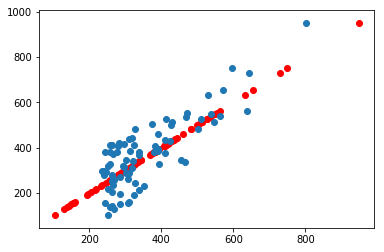

In [36]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures

poly_net = Pipeline([
    ("poly_features", PolynomialFeatures(degree=1)),
    ("lin_reg", ElasticNet(alpha=1))
])

model_net = poly_net.fit(X_train_trans, y_train)

score = poly_net.score(X_test_trans, y_test)
cross = cross_val_score(poly_net, X_train_trans, y_train, cv=5)
print("Accuracy: %0.4f (+/- %0.2f), Estimator: %s" % (cross.mean(), 2 *cross.std(), "Ridge"))
print(f"Score:{score}")

alpha = [x for x in np.arange(0,10,0.1)]
l1 = [x for x in np.arange(0,1,0.1)]
select = ["random", "cyclic"]
polys = [x for x in range(0,4)]
fit_int = [True, False]
normalize = [True, False]
precomp = [True, False]

best_params = {}
best_l1 = 0
best_selection = None
best_polyst = 0
best_precompute = None
best_score = 0
best_fit_intercept = None
best_normalize = None

for a in alpha:
    for l in l1:
        for s in select:
            for p in polys:
                for f in fit_int:
                    for n in normalize:
                        for pre in precomp:
                            model = Pipeline([
                                    ("poly_features", PolynomialFeatures(degree=p)),
                                    ("lin_reg", ElasticNet(alpha=a, 
                                                           l1_ratio=l, 
                                                           fit_intercept=f,
                                                           normalize=n,
                                                           precompute=pre,
                                                           random_state=2))])
                            model.fit(X_train_trans, y_train)
                            score = cross_val_score(model, X_train_trans, y_train, cv=5, n_jobs=-1).mean()
                            if score > best_score:
                                best_score = score
                                best_alpha = a
                                best_l1 = l
                                best_selection = s
                                best_precompute = pre
                                best_fit_intercept = f
                                best_normalize = n
                                best_polyst = p
                                best_params["alpha"] = best_alpha
                                best_params["l1"] = best_l1
                                best_params["selection"] = best_selection
                                best_params["precompute"] = best_precompute
                                best_params["fit_intercept"] = best_fit_intercept
                                best_params["normalize"] = best_normalize
                                best_params["degree"] = best_polyst
                                
print(best_params, score)


poly_net_tuned = Pipeline([
    ("poly_features", PolynomialFeatures(degree=best_params["degree"])),
    ("lin_reg", ElasticNet(alpha=best_params["alpha"],
                           l1_ratio=best_params["l1"], 
                           random_state=2,
                           fit_intercept=best_params["fit_intercept"],
                           normalize= best_params["normalize"],
                           precompute = best_params["precompute"],
                           selection = best_params["selection"] 
                           ))])

poly_net_tuned.fit(X_train_trans, y_train)
predicts = poly_net_tuned.predict(X_test_trans)
#print(f"True : {np.array(y_test)}")
#print(f"prediction: {predicts}")

plt.scatter(y_test,y_test, c="r")
plt.scatter(predicts, y_test)


In [45]:
filename = 'model_NET_tuned_without_limit.sav'
pickle.dump(poly_net_tuned, open(filename, 'wb'))

ran.fit(X_train_trans, y_train)
model_svr_tuned.fit(X_train_trans, y_train)

score_net = poly_net_tuned.score(X_test_trans, y_test)
score_ridge = poly_tuned.score(X_test_trans, y_test)
score_xgb = model_xgb_tuned.score(X_test_trans, y_test)
score_rf = ran.score(X_test_trans, y_test)
score_svr = model_svr_tuned.score(X_test_trans, y_test)

print(f"Net : {score_net}, Ridge : {score_ridge}, XGB : {score_xgb}, RandomForest : {score_rf}, SVR : {score_svr}")

Net : 0.6568654636392792, Ridge : 0.6586806815330906, XGB : 0.6591135354613579, RandomForest : 0.6495711031346958, SVR : 0.6523162192610511


Accuracy: 0.5968 (+/- 0.13), Estimator: Ridge
Score:0.6617791176626728


C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356674, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294345, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294345, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, 

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm d

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5880727264, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336698, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336698, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336698, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336698, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336698, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356674, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1023743.5872336631, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this alg

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356674, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this alg

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm d

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356674, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm d

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm d

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356674, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this alg

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm d

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.0685294466, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm d

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to inc

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.068529433, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this alg

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.068529433, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356578, tolerance: 4718.2391
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this alg

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.068529433, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.068529433, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, th

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452320.6421356709, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313889.068529433, tolerance: 767.8705096875001
  max_iter, tol, rng, random, positive)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:356: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mateusz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want

{'alpha': 0.7000000000000001, 'selection': 'random', 'precompute': True, 'fit_intercept': True, 'normalize': False, 'degree': 0} 0.553623509956368


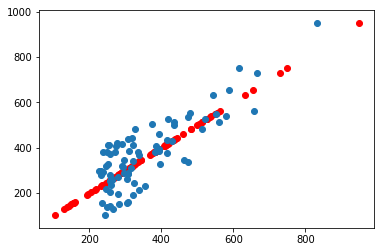

In [55]:
from sklearn.linear_model import Lasso

poly_lasso = Pipeline([
    ("poly_features", PolynomialFeatures(degree=1)),
    ("lin_reg", Lasso(alpha=1, random_state=2))
])

model_lasso = poly_lasso.fit(X_train_trans, y_train)

score = model_lasso.score(X_test_trans, y_test)
cross = cross_val_score(poly_lasso, X_train_trans, y_train, cv=5)
print("Accuracy: %0.4f (+/- %0.2f), Estimator: %s" % (cross.mean(), 2 *cross.std(), "Lasso"))
print(f"Score:{score}")

alpha = [x for x in np.arange(0,10,0.1)]
select = ["random", "cyclic"]
polys = [x for x in range(0,4)]
fit_int = [True, False]
normalize = [True, False]
precomp = [True, False]

best_params = {}
best_selection = None
best_polyst = 0
best_precompute = None
best_score = 0
best_fit_intercept = None
best_normalize = None

for a in alpha:
    for l in l1:
        for s in select:
            for p in polys:
                for f in fit_int:
                    for n in normalize:
                        for pre in precomp:
                            model = Pipeline([
                                    ("poly_features", PolynomialFeatures(degree=p)),
                                    ("lin_reg", Lasso(alpha=a,  
                                                           fit_intercept=f,
                                                           normalize=n,
                                                           precompute=pre,
                                                           random_state=2))])
                            model.fit(X_train_trans, y_train)
                            score = cross_val_score(model, X_train_trans, y_train, cv=5, n_jobs=-1).mean()
                            if score > best_score:
                                best_score = score
                                best_selection = s
                                best_precompute = pre
                                best_fit_intercept = f
                                best_normalize = n
                                best_polyst = p
                                best_params["alpha"] = best_alpha
                                best_params["selection"] = best_selection
                                best_params["precompute"] = best_precompute
                                best_params["fit_intercept"] = best_fit_intercept
                                best_params["normalize"] = best_normalize
                                best_params["degree"] = best_polyst
                                
print(best_params, score)


poly_lasso_tuned = Pipeline([
    ("poly_features", PolynomialFeatures(degree=best_params["degree"])),
    ("lin_reg", Lasso(alpha=best_params["alpha"], 
                           random_state=2,
                           fit_intercept=best_params["fit_intercept"],
                           normalize= best_params["normalize"],
                           precompute = best_params["precompute"],
                           selection = best_params["selection"] 
                           ))])

poly_lasso_tuned.fit(X_train_trans, y_train)
predicts = poly_lasso_tuned.predict(X_test_trans)
#print(f"True : {np.array(y_test)}")
#print(f"prediction: {predicts}")

plt.scatter(y_test,y_test, c="r")
plt.scatter(predicts, y_test)

Accuracy: 0.5897 (+/- 0.13), Estimator: Ridge
Score:0.66288362310328
{'alpha': 5, 'solver': 'saga', 'degree': 0} 0.4978832004364044


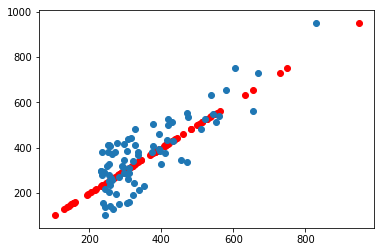

In [32]:
from sklearn.linear_model import ridge_regression, Ridge


poly = Pipeline([
    ("poly_features", PolynomialFeatures(degree=1)),
    ("lin_reg", Ridge(alpha=1))
])

model = poly.fit(X_train_trans, y_train)

score = poly.score(X_test_trans, y_test)
cross = cross_val_score(poly, X_train_trans, y_train, cv=5)
print("Accuracy: %0.4f (+/- %0.2f), Estimator: %s" % (cross.mean(), 2 *cross.std(), "Ridge"))
print(f"Score:{score}")
alpha = [0, 0.01, 0.05, 0.1, 0.5, 1,2,5,10]
#solver = ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"] 
#solver =["sag"]
solver = ["auto", "lsqr", "sag", "saga"]
polys = [x for x in range(0,4)]
best_params = {}
best_alpha = 0
best_solver = None
best_polyst = 0
best_score = 0
for a in alpha:
    for s in solver:
        for p in polys:
            model = Pipeline([
                ("poly_features", PolynomialFeatures(degree=p)),
                ("lin_reg", Ridge(alpha=a, solver=s, fit_intercept=False, random_state=2))])
            model.fit(X_train_trans, y_train)
            score = cross_val_score(model, X_train_trans, y_train, cv=5, n_jobs=-1).mean()
            if score > best_score:
                best_score = score
                best_alpha = a
                best_solver = s
                best_polyst = p
                best_params["alpha"] = best_alpha
                best_params["solver"] = best_solver
                best_params["degree"] = best_polyst
print(best_params, score)

poly_tuned = Pipeline([
    ("poly_features", PolynomialFeatures(degree=best_params["degree"])),
    ("lin_reg", Ridge(alpha=best_params["alpha"], solver=best_params["solver"], random_state=2,fit_intercept=False))
])

poly_tuned.fit(X_train_trans, y_train)
predicts = poly_tuned.predict(X_test_trans)
#print(f"True : {np.array(y_test)}")
#print(f"prediction: {predicts}")

plt.scatter(y_test,y_test, c="r")
plt.scatter(predicts, y_test)

In [57]:
filename = 'model_Lasso_tuned_without_limit.sav'
pickle.dump(poly_lasso_tuned, open(filename, 'wb'))

ran.fit(X_train_trans, y_train)
model_svr_tuned.fit(X_train_trans, y_train)

score_net = poly_net_tuned.score(X_test_trans, y_test)
score_ridge = poly_tuned.score(X_test_trans, y_test)
score_lasso = poly_lasso_tuned.score(X_test_trans, y_test)
score_xgb = model_xgb_tuned.score(X_test_trans, y_test)
score_rf = ran.score(X_test_trans, y_test)
score_svr = model_svr_tuned.score(X_test_trans, y_test)

print(f"Net : {score_net}, Ridge : {score_ridge}, Lasso : {score_lasso}, XGB : {score_xgb}, RandomForest : {score_rf}, SVR : {score_svr}")

Net : 0.6568654636392792, Ridge : 0.6586806815330906, Lasso : 0.6618442041929145, XGB : 0.6591135354613579, RandomForest : 0.6495711031346958, SVR : 0.6523162192610511


In [59]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

vote_clf = VotingRegressor(estimators=[('xgb', model_xgb_tuned),("linear", poly_tuned), 
                                       ("net", poly_net_tuned), ("svr", model_svr_tuned), ("lasso", poly_lasso_tuned)])

for clf, label in zip([model_xgb_tuned,  poly_tuned, poly_net_tuned, poly_lasso_tuned,model_svr_tuned,vote_clf], 
                      ['xgb',"Linear","Net","lasso","SVR",'Ensemble']):
    test_scores = cross_val_score(clf, X_train_trans, y_train, cv=5)
    print("Accuracy: %0.4f (+/- %0.2f), Estimator: %s" % (test_scores.mean(), 2 * test_scores.std(), label))

[11:15:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: 0.5903 (+/- 0.12), Estimator: xgb
Accuracy: 0.5900 (+/- 0.12), Estimator: Linear
Accuracy: 0.5946 (+/- 0.12), Estimator: Net
Accuracy: 0.5948 (+/- 0.13), Estimator: lasso

In [68]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

vote_clf = VotingRegressor(estimators=[
                                       ("net", poly_net_tuned), ("lasso", poly_lasso_tuned)])

for clf, label in zip([poly_net_tuned, poly_lasso_tuned, vote_clf], 
                      ["Net","lasso",'Ensemble']):
    test_scores = cross_val_score(clf, X_train_trans, y_train, cv=5)
    print("Accuracy: %0.4f (+/- %0.2f), Estimator: %s" % (test_scores.mean(), 2 * test_scores.std(), label))
    
filename = 'model_Lasso+Net_the_best.sav'
pickle.dump(vote_clf, open(filename, 'wb'))

score_vote = vote_clf.fit(X_train_trans,y_train).score(X_test_trans, y_test)
print(score_vote)

Accuracy: 0.5946 (+/- 0.12), Estimator: Net
Accuracy: 0.5948 (+/- 0.13), Estimator: lasso
Accuracy: 0.5954 (+/- 0.12), Estimator: Ensemble
0.6600567892834229


In [70]:
filename = 'model_Lasso_tuned_without_limit.sav'
pickle.dump(poly_lasso_tuned, open(filename, 'wb'))

ran.fit(X_train_trans, y_train)
model_svr_tuned.fit(X_train_trans, y_train)

score_net = poly_net_tuned.score(X_test_trans, y_test)
score_ridge = poly_tuned.score(X_test_trans, y_test)
score_lasso = poly_lasso_tuned.score(X_test_trans, y_test)
score_xgb = model_xgb_tuned.score(X_test_trans, y_test)
score_rf = ran.score(X_test_trans, y_test)
score_svr = model_svr_tuned.score(X_test_trans, y_test)
score_vote = vote_clf.fit(X_train_trans,y_train).score(X_test_trans, y_test)

print(f"Net : {score_net}, Ridge : {score_ridge}, Lasso : {score_lasso}, XGB : {score_xgb}, RandomForest : {score_rf}, SVR : {score_svr}, Vote: {score_vote}")

Net : 0.6568654636392792, Ridge : 0.6586806815330906, Lasso : 0.6618442041929145, XGB : 0.6591135354613579, RandomForest : 0.6495711031346958, SVR : 0.6523162192610511, Vote: 0.6600567892834229


In [52]:
from sklearn.ensemble import BaggingRegressor

for n in range(2,50,3):
    bagging = BaggingRegressor(model_xgb_tuned, n_estimators=n, random_state=0)
    # We take only two features from the data `iris_data[:,1:3]` to make problem harder and more interesting.
    test_scores = cross_val_score(bagging, X_train_trans,y_train, cv=5)
    print("Test accuracy of {:2d} XGB model: {:0.4f} (+/- {:0.2f})".format(n, test_scores.mean(), 2 * test_scores.std()))

[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNI

[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:52] WARNI

[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNI

[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNI

[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:53] WARNI

Test accuracy of 17 XGB model: 0.5906 (+/- 0.12)
[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecat

[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:54] WARNI

[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNI

[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNI

[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test accuracy of 23 XGB model: 0.5899 (+/- 0.12)
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecat

[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:56] WARNI

[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test accuracy of 26 XGB model: 0.5903 (+/- 0.12)
[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecat

[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNI

[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:57] WARNI

[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNI

[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:58] WARNI

[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNI

[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNI

[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:31:59] WARNI

[00:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:00] WARNI

[00:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNI

[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNI

[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:01] WARNI

[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNI

[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:02] WARNI

[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNI

[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:03] WARNI

[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNI

[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:04] WARNI

[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNI

[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNI

[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:05] WARNI

[00:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:06] WARNI

In [41]:
for n in range(2,100,3):
    bagging = BaggingRegressor(poly_tuned, n_estimators=n, random_state=0)
    test_scores = cross_val_score(bagging, X_train_trans,y_train, cv=5)
    print("Test accuracy of {:2d} Ridge model: {:0.4f} (+/- {:0.2f})".format(n, test_scores.mean(), 2 * test_scores.std()))

Test accuracy of  2 Ridge model: 0.5770 (+/- 0.13)
Test accuracy of  5 Ridge model: 0.5859 (+/- 0.12)
Test accuracy of  8 Ridge model: 0.5888 (+/- 0.12)
Test accuracy of 11 Ridge model: 0.5896 (+/- 0.12)
Test accuracy of 14 Ridge model: 0.5900 (+/- 0.12)
Test accuracy of 17 Ridge model: 0.5904 (+/- 0.12)
Test accuracy of 20 Ridge model: 0.5902 (+/- 0.12)
Test accuracy of 23 Ridge model: 0.5897 (+/- 0.12)
Test accuracy of 26 Ridge model: 0.5901 (+/- 0.12)
Test accuracy of 29 Ridge model: 0.5904 (+/- 0.12)
Test accuracy of 32 Ridge model: 0.5893 (+/- 0.12)
Test accuracy of 35 Ridge model: 0.5894 (+/- 0.12)
Test accuracy of 38 Ridge model: 0.5896 (+/- 0.12)
Test accuracy of 41 Ridge model: 0.5893 (+/- 0.12)
Test accuracy of 44 Ridge model: 0.5894 (+/- 0.12)
Test accuracy of 47 Ridge model: 0.5895 (+/- 0.12)
Test accuracy of 50 Ridge model: 0.5889 (+/- 0.12)
Test accuracy of 53 Ridge model: 0.5885 (+/- 0.12)
Test accuracy of 56 Ridge model: 0.5890 (+/- 0.12)
Test accuracy of 59 Ridge model

In [65]:
for n in range(2,30,3):
    bagging = BaggingRegressor(vote_clf, n_estimators=n, random_state=2)
    # We take only two features from the data `iris_data[:,1:3]` to make problem harder and more interesting.
    #test_scores = cross_val_score(bagging, X_train_trans, y_train, cv=5)
    bagging.fit(X_train_trans, y_train).score(X_train_trans, y_train)
    print("Test accuracy of {:2d} Vote model: {:0.4f} (+/- {:0.2f})".format(n, test_scores.mean(), 2 * test_scores.std()))

ValueError: Pipeline.fit does not accept the sample_weight parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

In [40]:
for n in range(2,100,3):
    bagging = BaggingRegressor(poly_net_tuned, n_estimators=n, random_state=0)
    test_scores = cross_val_score(bagging, X_train_trans,y_train, cv=5)
    print("Test accuracy of {:2d} Net model: {:0.4f} (+/- {:0.2f})".format(n, test_scores.mean(), 2 * test_scores.std()))

Test accuracy of  2 Ridge model: 0.5836 (+/- 0.12)
Test accuracy of  5 Ridge model: 0.5909 (+/- 0.12)
Test accuracy of  8 Ridge model: 0.5927 (+/- 0.12)
Test accuracy of 11 Ridge model: 0.5926 (+/- 0.12)
Test accuracy of 14 Ridge model: 0.5928 (+/- 0.12)
Test accuracy of 17 Ridge model: 0.5929 (+/- 0.12)
Test accuracy of 20 Ridge model: 0.5925 (+/- 0.12)
Test accuracy of 23 Ridge model: 0.5927 (+/- 0.12)
Test accuracy of 26 Ridge model: 0.5928 (+/- 0.12)
Test accuracy of 29 Ridge model: 0.5926 (+/- 0.12)
Test accuracy of 32 Ridge model: 0.5918 (+/- 0.12)
Test accuracy of 35 Ridge model: 0.5914 (+/- 0.12)
Test accuracy of 38 Ridge model: 0.5916 (+/- 0.12)
Test accuracy of 41 Ridge model: 0.5914 (+/- 0.12)
Test accuracy of 44 Ridge model: 0.5916 (+/- 0.12)
Test accuracy of 47 Ridge model: 0.5919 (+/- 0.12)
Test accuracy of 50 Ridge model: 0.5916 (+/- 0.12)
Test accuracy of 53 Ridge model: 0.5913 (+/- 0.12)
Test accuracy of 56 Ridge model: 0.5918 (+/- 0.12)
Test accuracy of 59 Ridge model

In [50]:
for n in range(2,100,3):
    bagging = BaggingRegressor(model_svr_tuned, n_estimators=n, random_state=0)
    test_scores = cross_val_score(bagging, X_train_trans,y_train, cv=5)
    print("Test accuracy of {:2d} SVR model: {:0.4f} (+/- {:0.2f})".format(n, test_scores.mean(), 2 * test_scores.std()))

Test accuracy of  2 Net model: 0.5604 (+/- 0.17)
Test accuracy of  5 Net model: 0.5798 (+/- 0.13)
Test accuracy of  8 Net model: 0.5802 (+/- 0.12)
Test accuracy of 11 Net model: 0.5820 (+/- 0.13)
Test accuracy of 14 Net model: 0.5815 (+/- 0.13)
Test accuracy of 17 Net model: 0.5814 (+/- 0.12)
Test accuracy of 20 Net model: 0.5810 (+/- 0.13)
Test accuracy of 23 Net model: 0.5801 (+/- 0.13)
Test accuracy of 26 Net model: 0.5803 (+/- 0.13)
Test accuracy of 29 Net model: 0.5796 (+/- 0.13)
Test accuracy of 32 Net model: 0.5784 (+/- 0.13)
Test accuracy of 35 Net model: 0.5781 (+/- 0.13)
Test accuracy of 38 Net model: 0.5773 (+/- 0.13)
Test accuracy of 41 Net model: 0.5773 (+/- 0.13)
Test accuracy of 44 Net model: 0.5776 (+/- 0.13)
Test accuracy of 47 Net model: 0.5784 (+/- 0.12)
Test accuracy of 50 Net model: 0.5779 (+/- 0.12)
Test accuracy of 53 Net model: 0.5775 (+/- 0.12)
Test accuracy of 56 Net model: 0.5782 (+/- 0.12)
Test accuracy of 59 Net model: 0.5785 (+/- 0.12)
Test accuracy of 62 

In [64]:
for n in range(2,18,3):
    bagging = BaggingRegressor(poly_lasso_tuned, n_estimators=n, random_state=0)
    test_scores = cross_val_score(bagging, X_train_trans,y_train, cv=5)
    print("Test accuracy of {:2d} Lasso model: {:0.4f} (+/- {:0.2f})".format(n, test_scores.mean(), 2 * test_scores.std()))

Test accuracy of  2 Lasso model: 0.5827 (+/- 0.13)
Test accuracy of  5 Lasso model: 0.5895 (+/- 0.13)
Test accuracy of  8 Lasso model: 0.5924 (+/- 0.13)
Test accuracy of 11 Lasso model: 0.5924 (+/- 0.13)
Test accuracy of 14 Lasso model: 0.5927 (+/- 0.13)
Test accuracy of 17 Lasso model: 0.5929 (+/- 0.13)
